<a href="https://colab.research.google.com/github/UdirL18/Horizontalno-prekrivanje-poligonov/blob/main/Horizontalno_prekrivanje_poligonov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Horizontalno prekrivanje poligonov**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import ipywidgets as widgets
from shapely.geometry import Polygon
import scipy.optimize
import random
from math import atan2
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# plt.style.use('science')

Za generiranje poligonov bova uporabila tri metode.

## 1. način



In [2]:
def to_convex_contour(vertices_count,
                      x_generator=random.random,
                      y_generator=random.random):

    xs = [x_generator() for _ in range(vertices_count)]
    ys = [y_generator() for _ in range(vertices_count)]
    xs = sorted(xs)
    ys = sorted(ys)
    min_x, *xs, max_x = xs
    min_y, *ys, max_y = ys
    vectors_xs = _to_vectors_coordinates(xs, min_x, max_x)
    vectors_ys = _to_vectors_coordinates(ys, min_y, max_y)
    random.shuffle(vectors_ys)

    def to_vector_angle(vector):
        x, y = vector
        return atan2(y, x)

    vectors = sorted(zip(vectors_xs, vectors_ys),
                     key=to_vector_angle)
    point_x = point_y = 0
    min_polygon_x = min_polygon_y = 0
    points = []
    for vector_x, vector_y in vectors:
        points.append((point_x, point_y))
        point_x += vector_x
        point_y += vector_y
        min_polygon_x = min(min_polygon_x, point_x)
        min_polygon_y = min(min_polygon_y, point_y)
    shift_x, shift_y = min_x - min_polygon_x, min_y - min_polygon_y
    return [(point_x + shift_x, point_y + shift_y)
            for point_x, point_y in points]


def _to_vectors_coordinates(coordinates, min_coordinate, max_coordinate):
    last_min = last_max = min_coordinate
    result = []
    for coordinate in coordinates:
        if _to_random_boolean():
            result.append(coordinate - last_min)
            last_min = coordinate
        else:
            result.append(last_max - coordinate)
            last_max = coordinate
    result.extend((max_coordinate - last_min,
                   last_max - max_coordinate))
    return result


def _to_random_boolean():
    return random.getrandbits(1)

In [3]:
#1. primer: 1000 in 10000 kotnik
poly1_1 = Polygon(to_convex_contour(10000000))
poly2_1 = Polygon(to_convex_contour(10000000))

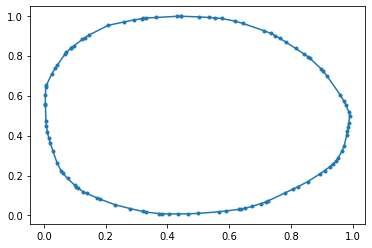

In [4]:
# Izrisane generirane random tocke (1000 stranega konveksnega poligona)
# izrise nov poligon ne tistega od zgoraj
x, y = np.array(to_convex_contour(100)).T
x = np.append(x, x[0])
y = np.append(y, y[0])
plt.savefig('nacin_1.pdf', bbox_inches='tight') 

plt.plot(x,y, '.-')
plt.savefig('nacin_1.pdf', bbox_inches='tight')

## 2. način generiraja - s pomočjo konveksne ovojnice.

In [5]:
points = np.random.randn(1000, 2)   # 1000 random points normalno porazdaljene in 2-D
hull = ConvexHull(points)

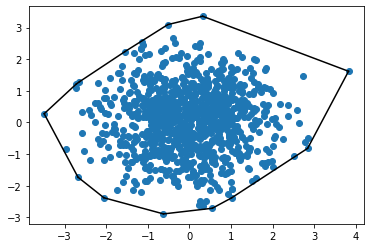

In [6]:
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

# ZA SHRANJEVANJE SLIKE ZA pdf
#plt.savefig('nacin_2.pdf', bbox_inches='tight')    

In [7]:
# 2. primer
points = np.random.randn(1000, 2)   # 1000 random points normalno porazdaljene in 2-D
hull = ConvexHull(points)
poly1_2 = Polygon(points[hull.vertices,:])

points = np.random.randn(100, 2)   # 1000 random points normalno porazdaljene in 2-D
hull = ConvexHull(points)
poly2_2 = Polygon(points[hull.vertices,:])

## 3. način - počasna za velike n-je (na roke implementirana metoda)

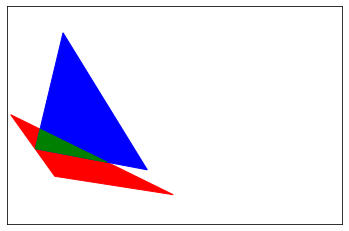

In [8]:
# GENERIRANJE POLJUBNEGA 3-KOTNIKA V RAVNINI
np.random.seed(9)  # zacetnja vrednost za generator nakljucnih stevil
poly1 = Polygon(np.random.rand(3,2))  # np.random.rand(m,n) matrika mxn nakljucnih stevil
poly2 = Polygon(np.random.rand(3,2))  # Polygon izrise poligon z danimi koordinatami (3-kotnik, v 2D) 

poly_inter = poly1.intersection(poly2)  # presek teh dveh poligonov -vrne koordinate preseka

# GRAF
p1 = plt.Polygon(poly1.exterior.coords, color='r')  # zapise tocke ogljisc, naredi poligon iz teh tock
plt.gca().add_patch(p1)  # doda ta poligon na sliko

p2 = plt.Polygon(poly2.exterior.coords, color='b')
plt.gca().add_patch(p2)

p3 = plt.Polygon(poly_inter.exterior.coords, color='g')
plt.gca().add_patch(p3)

plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)  # koordinatni sistem nima oznak

Trikotniki so vedno konveksni. Problem bi radi resevali za poljubne konveksne mnogokotnike. V ta namen moramo sestaviti funkcijo, ki bo preverila ali je poligon konveksen in funkcijo, ki bo zgenerirala taksen poligon.

In [9]:
# FUNKCIJA ZA PREVERJANJE ALI JE POLIGON KONVEKSEN
TWO_PI = 2 * math.pi

def is_convex_polygon(polygon):
    """Return True if the polynomial defined by the sequence of 2D
    points is 'strictly convex': points are valid, side lengths non-
    zero, interior angles are strictly between zero and a straight
    angle, and the polygon does not intersect itself.

    NOTES:  1.  Algorithm: the signed changes of the direction angles
                from one side to the next side must be all positive or
                all negative, and their sum must equal plus-or-minus
                one full turn (2 pi radians). Also check for too few,
                invalid, or repeated points.
            2.  No check is explicitly done for zero internal angles
                (180 degree direction-change angle) as this is covered
                in other ways, including the `n < 3` check.
    """
    try:  # needed for any bad points or direction changes   # ce pride do errorja gre koda v except
        # Check for too few points
        if len(polygon) < 3:  # ce ni vsaj trikotnik
            return False
        # Get starting information
        old_x, old_y = polygon[-2]  # predzadnji x in y iz polygon 
        new_x, new_y = polygon[-1]  # zadnji x in y iz polygon
        new_direction = math.atan2(new_y - old_y, new_x - old_x)  # vrne arctg(new_y - old_y / new_x - old_x) v radijanih med pi in -pi 
        angle_sum = 0.0
        # Check each point (the side ending there, its angle) and accum. angles
        for ndx, newpoint in enumerate(polygon):  # ostevilcimo
            # Update point coordinates and side directions, check side length
            old_x, old_y, old_direction = new_x, new_y, new_direction
            new_x, new_y = newpoint
            new_direction = math.atan2(new_y - old_y, new_x - old_x)
            if old_x == new_x and old_y == new_y:
                return False  # ce je spet ista tocka ni ok
            # Calculate & check the normalized direction-change angle
            angle = new_direction - old_direction  # razlika dveh kotov
            if angle <= -math.pi:  # ce je kot manjsi od -pi 
                angle += TWO_PI  # make it in half-open interval (-Pi, Pi]
            elif angle > math.pi:
                angle -= TWO_PI
            if ndx == 0:  # if first time through loop, initialize orientation
                if angle == 0.0:
                    return False
                orientation = 1.0 if angle > 0.0 else -1.0
            else:  # if other time through loop, check orientation is stable
                if orientation * angle <= 0.0:  # not both pos. or both neg.
                    return False
            # Accumulate the direction-change angle
            angle_sum += angle
        # Check that the total number of full turns is plus-or-minus 1
        return abs(round(angle_sum / TWO_PI)) == 1
    except (ArithmeticError, TypeError, ValueError):
        return False  # any exception means not a proper convex polygon

In [10]:
# FUNKCIJA ZA GENERIRANJE NAKLJUCNIH POLIGONOV
def gen_rand_poly(n=3):
    for i in range(1_000_000):
        cords = np.random.rand(n, 2)  # matrika z n vrsticami in 2 stolpcema 
        u = np.argsort(np.arctan2(*cords.T))  # .T transponira koordinate, argsort vrne indekse ki bi uredili array
 
        cords = cords[u, :]  # uredimo koordinate po velikosti
        if is_convex_polygon(cords):
            return Polygon(cords)  # ce je poligon konveksen "izrise" poligon

In [11]:
# IZRIS POLIGONOV
def plot_polys(*args):
    for i, poly in enumerate(args):
        cords = np.array(poly.exterior.coords)[:-1, :]
        plt.scatter(*cords.T, s=0)  # narise tocke
        p = plt.Polygon(cords, color=get_cmap('Set1')(i), alpha=0.7)
        plt.gca().add_patch(p)
        plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

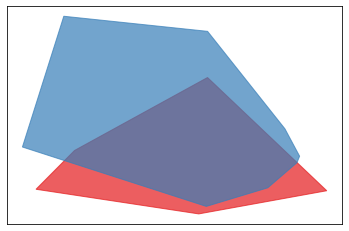

In [12]:
# 3. primer
poly1_3 = gen_rand_poly(5)
poly2_3 = gen_rand_poly(8)

plot_polys(poly1_3, poly2_3)

## Iskanje minimalnega premika

Za iskanje minimalnega vodoravnega premika sestavimo funkcijo, ki omogoca premikanje poligonov na sliki.

In [13]:
def move_polygon(poly, x):
    cords = np.array(poly.exterior.coords)[:-1,:]  # koordinate oglisc zapise v np.array
    cords[:, 0] += x  # vse x koordinate premakne za dani x
    poly = Polygon(cords) 
    return poly  # vrne premaknen poligon

In [14]:
poligoni = {1: (poly1_1, poly2_1),
            2: (poly1_2, poly2_2),
            3: (poly1_3, poly2_3)}
# FUNKCIJA, KI NAM OMOGOCA PREMIKANJE POLIGONOV S POMOCJO 'SLAJDERJA'.
def move_windget_fun(x=0, nacin=3):
    poly_slider_1, poly_slider_2 = poligoni[nacin]

    fig, ax = plt.subplots()
    
    poly = move_polygon(poly_slider_1, x=x)
    plot_polys(poly_slider_2, poly)
    
    dist = poly.distance(poly_slider_2)
    txt = f'presek = 0.0000\nrazdalja = {dist:.4f}'

    if poly.intersects(poly_slider_2):
        poly3 = poly.intersection(poly_slider_2)
        p3 = plt.Polygon(poly3.exterior.coords, color=get_cmap('Set1')(2))
        ax.add_patch(p3)
        txt = f'presek = {poly3.area:.4f}\nrazdalja = {dist:.4f}'
    
    ax.text(1,1,txt, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
#     plt.xlim(-1, 1)
#     plt.ylim(-1, 1)
    plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
    plt.show()

widgets.interact(move_windget_fun, x=(-5, 5, 0.1), nacin=[1,2,3]);

interactive(children=(FloatSlider(value=0.0, description='x', max=5.0, min=-5.0), Dropdown(description='nacin'…

Zapiseva funkcijo, ki bo poiskala potreben minimalni premik rdečega poligona v smeri abcisne osi, da rdeč in moder poligon postaneta disjunkta.

In [15]:
def optimize_fun(x, poly1, poly2):
    poly = move_polygon(poly1, x)
    A = poly.intersection(poly2).area  # ploscina (npr. 0.010113566098373444)
    d = poly.distance(poly2)  # ce se prekrivata
    return A - d  # ko bosta poligona disjunktna se bo d poveceval in bo ta vrednost vedno manjsa, ko no A > 0 bo d enak nic, poiskati moramo ničlo te funkcije

In [16]:
poligoni = {1: (poly1_1, poly2_1),
            2: (poly1_2, poly2_2),
            3: (poly1_3, poly2_3)}

def widget_fun(nacin=3):
    poly1, poly2 = poligoni[nacin]

    # IZRIS GRAFA
    xx = np.linspace(-5, 5, 100)
    y = np.vectorize(optimize_fun)(xx, poly1, poly2)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.axhline(0, c='k', ls='--', alpha=0.8)
    ax.plot(xx, y)
    ax.set_xlabel("razdalja od izhodišča")
    # ax.grid(ls='--')

    # ISKANJE NIČEL - tj rdeči pikici na grafu
    x1 = scipy.optimize.newton(optimize_fun, x0=0.5, args=(poly1, poly2))
    ax.plot(x1, 0, 'ro')
    ax.text(x1, 0, f'{x1:.4f}', fontsize=14, c='r')

    x2 = scipy.optimize.newton(optimize_fun, x0=-0.5, args=(poly1, poly2))
    ax.plot(x2, 0, 'ro')
    ax.text(x2, 0, f'{x2:.4f}', fontsize=14, c='r', horizontalalignment='right')

# ZA SHRANJEVANJE SLIKE ZA pdf
#plt.savefig('funkcija.pdf', bbox_inches='tight')

widgets.interact(widget_fun, nacin=[1,2,3]);


interactive(children=(Dropdown(description='nacin', index=2, options=(1, 2, 3), value=3), Output()), _dom_clas…

Izračun najmanjse ničle po absolutni vrednosti zgornje funkcije.

In [17]:
def calc_min_distance(poly1, poly2):
    min_dist_p = scipy.optimize.newton(optimize_fun, x0=0.5, args=(poly1, poly2))
    min_dist_m = scipy.optimize.newton(optimize_fun, x0=-0.5, args=(poly1, poly2))

    razdalje = np.array([min_dist_p, min_dist_m])
    id_min = np.argmin(np.abs(razdalje))

    return razdalje[id_min]

In [18]:
min_dist = calc_min_distance(poly1_3, poly2_3)
print(f'Najmanjša razdalja za premik rdečega poligona je {min_dist:.10f}')

Najmanjša razdalja za premik rdečega poligona je 0.6098096057


In [19]:
poligoni = {1: (poly1_1, poly2_1),
            2: (poly1_2, poly2_2),
            3: (poly1_3, poly2_3)}
# FUNKCIJA, KI NAM OMOGOCA PREMIKANJE POLIGONOV S POMOCJO 'SLAJDERJA'.
def move_windget_fun(nacin=3):
    poly_slider_1, poly_slider_2 = poligoni[nacin]

    fig, ax = plt.subplots()
    
    plot_polys(poly_slider_1, poly_slider_2)
    min_dist = calc_min_distance(poly_slider_1, poly_slider_2)
    poly = move_polygon(poly_slider_1, x=min_dist)
    plot_polys(poly)

    plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

    plt.title(f'Najmanjša razdalja za premik rdečega poligona') #je {min_dist:.10f}')
    #plt.savefig('premikr.pdf', bbox_inches='tight')
    plt.show()
    

widgets.interact(move_windget_fun, nacin=[1,2,3]); 

interactive(children=(Dropdown(description='nacin', index=2, options=(1, 2, 3), value=3), Output()), _dom_clas…